In this notebook we show the process to train and deploy a model primarily utilizing Python and Docker.

The data of interest is the titanic data where we predict whether a passenger survive or not.

Data source: [kaggle](https://www.kaggle.com/competitions/titanic/data).

In [187]:
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,  precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import os

In [5]:
dir = os.getcwd()

In [46]:
train = pd.read_csv(dir+"/data/train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Data Cleaning and Preprocessing

We remove PassengerId, Name, Cabin, and Ticket from the data.

In [47]:
train_new = train.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1)

In [48]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Now, we fill the missing value in the age with the mean, and that of Embarked with the mode.

In [50]:
mode_embarked = train_new.Embarked.mode()
print('Mode of Embarked:' ,mode_embarked) 

Mode of Embarked: 0    S
Name: Embarked, dtype: object


In [51]:
mean_age = round(train_new.Age.mean(), 2)

print('Mean age:', mean_age)
print('Mode of Embarked:' ,mode_embarked[0]) 

Mean age: 29.7
Mode of Embarked: S


In [52]:
mode_embarked[0]

'S'

In [60]:
# train_new.fillna({train_new['Age']:mean_age}, inplace=True)
# train_new.fillna({train_new['Embarked']:mode_embarked[0]}, inplace=True)

In [61]:
train_new.Age.fillna(mean_age, inplace=True)
train_new.Embarked.fillna(mode_embarked[0], inplace=True)

C:\Users\oluse\AppData\Local\Temp\ipykernel_15808\79752813.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_new.Age.fillna(mean_age, inplace=True)


In [62]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


# EDA

In [73]:
train_new.Embarked.value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

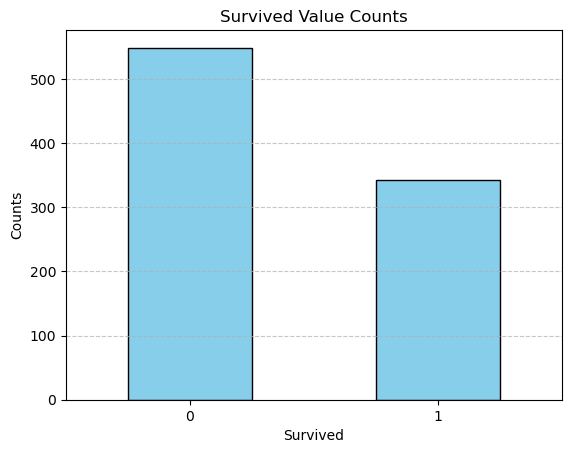

In [83]:
train_new.Survived.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Survived Value Counts')
plt.xlabel('Survived')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Keep labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

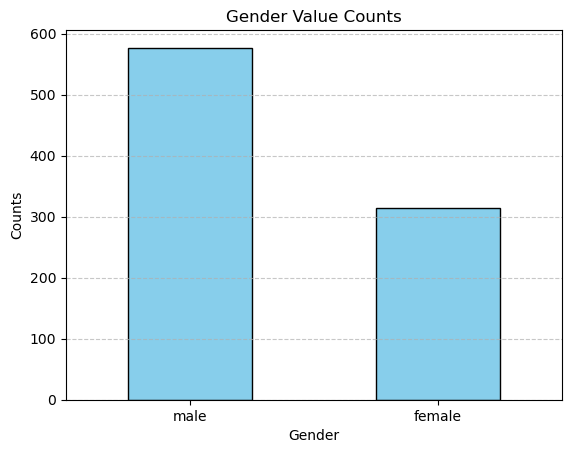

In [81]:
train_new.Sex.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Gender Value Counts')
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Keep labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

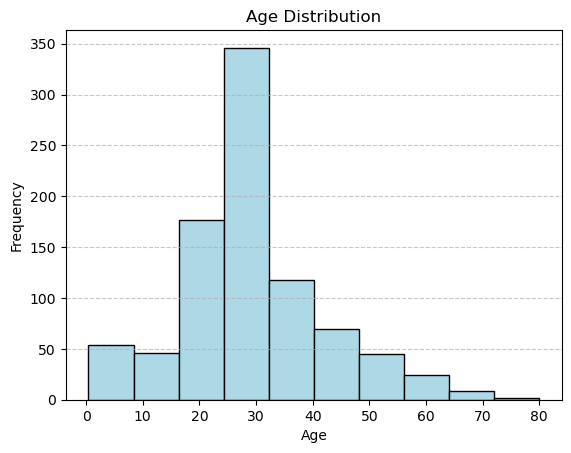

In [79]:
# a histogram
train_new['Age'].plot.hist(bins=10, color='lightblue', edgecolor='black')

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

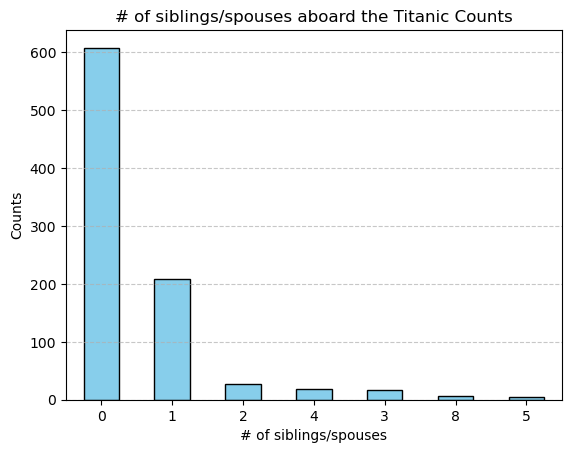

In [86]:
train_new.SibSp.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('# of siblings/spouses aboard the Titanic Counts')
plt.xlabel('# of siblings/spouses')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Keep labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

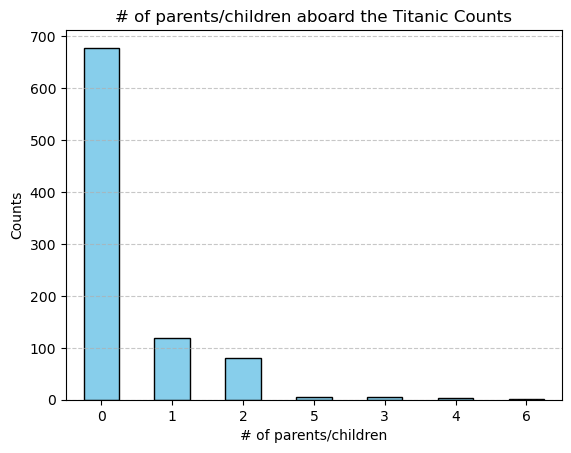

In [88]:
train_new.Parch.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('# of parents/children aboard the Titanic Counts')
plt.xlabel('# of parents/children')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Keep labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

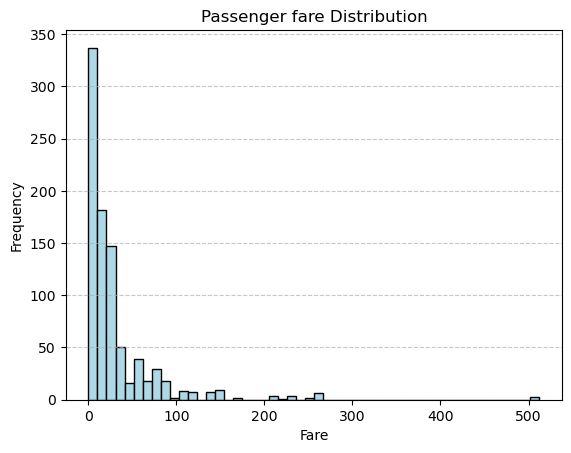

In [104]:
# a histogram
train_new['Fare'].plot.hist(bins=50, color='lightblue', edgecolor='black')

plt.title('Passenger fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

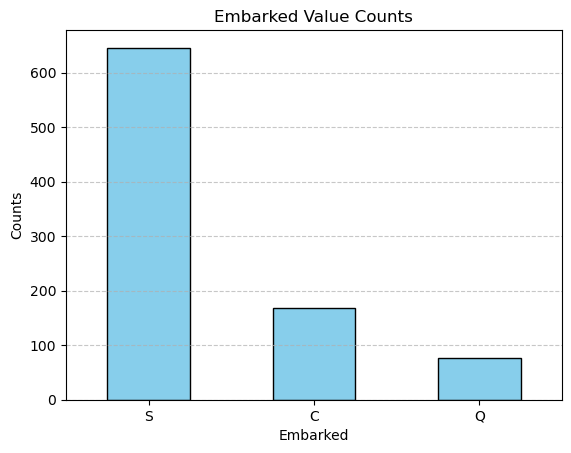

In [89]:
train_new.Embarked.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Embarked Value Counts')
plt.xlabel('Embarked')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Keep labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Now, we do some bivariate plots.

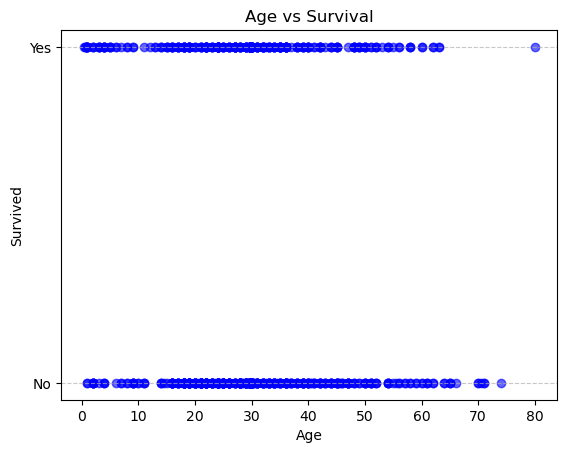

In [96]:
# Scatter plot
plt.scatter(train_new['Age'], train_new['Survived'], color='blue', alpha=0.6)

# Customize the plot
plt.title('Age vs Survival')
plt.xlabel('Age')
plt.ylabel('Survived')
plt.yticks([0, 1], ['No', 'Yes'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

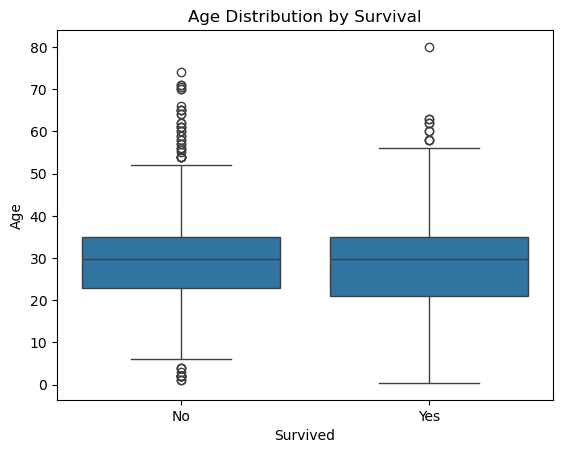

In [102]:
# Boxplot
sns.boxplot(x='Survived', y='Age', data=train_new)

# Customize the plot
plt.title('Age Distribution by Survival')
plt.xlabel('Survived')
plt.ylabel('Age')
plt.xticks([0, 1], ['No', 'Yes'])

# Show the plot
plt.show()

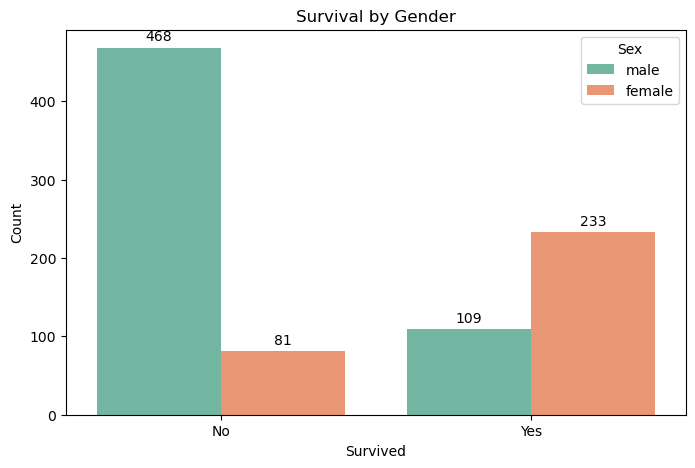

In [101]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Survived', hue='Sex', data=train_new, palette='Set2')

# Annotate the bars with their values
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Customize the plot
plt.title('Survival by Gender')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])

# Show the plot
plt.show()

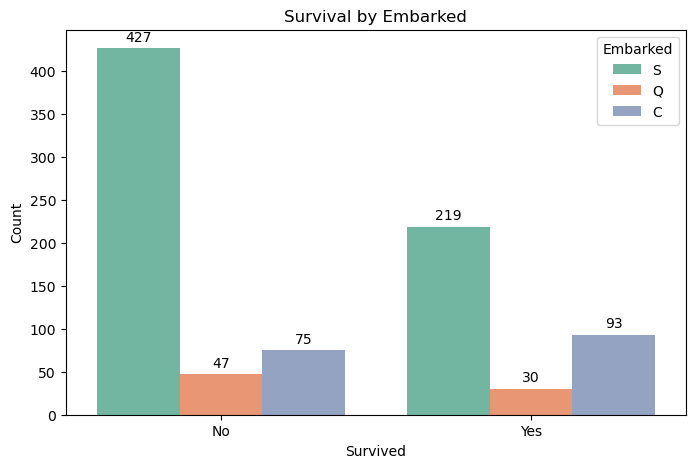

In [105]:
# Create a count plot for Survived and Embarked
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Survived', hue='Embarked', data=train_new, palette='Set2')

# Annotate the bars with their values
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Customize the plot
plt.title('Survival by Embarked')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])

# Show the plot
plt.show()

C:\Users\oluse\AppData\Local\Temp\ipykernel_15808\730694133.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Survived', y='Fare', data=train_new, palette='Set2')


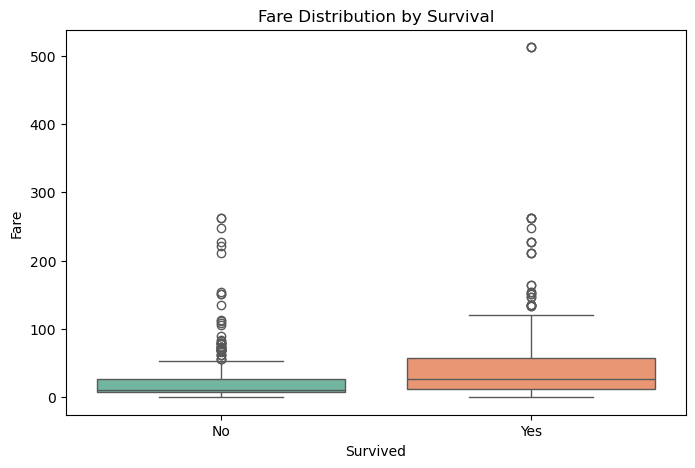

In [107]:
# Create a boxplot for Fare and Survived
plt.figure(figsize=(8, 5))
sns.boxplot(x='Survived', y='Fare', data=train_new, palette='Set2')

# Customize the plot
plt.title('Fare Distribution by Survival')
plt.xlabel('Survived')
plt.ylabel('Fare')
plt.xticks([0, 1], ['No', 'Yes'])

# Show the plot
plt.show()

# Models

At the end of our EDA, we build some models. We use the Logistic Regression, and Naive Bayes Model to solve the classification problem.

In [108]:
train_new

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,29.7,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [109]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [117]:
y = train_new.Survived
X = train_new.drop(['Survived'], axis=1)

In [119]:
categorical_columns = list(X.dtypes[X.dtypes == 'object'].index)
numerical_columns = list(X.dtypes[X.dtypes != 'object'].index)
categorical_columns, numerical_columns

(['Sex', 'Embarked'], ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])

In [121]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [169]:
from sklearn.feature_extraction import DictVectorizer

def transform_to_vector(X, dv=None):
    """
    Transforms a DataFrame into a vectorized format using DictVectorizer.

    Parameters:
    X (pd.DataFrame): The input DataFrame to be transformed.
    dv (DictVectorizer, optional): A pre-fitted DictVectorizer instance. 
                                   If None, a new instance will be created and fitted.

    Returns:
    sparse_matrix: The vectorized sparse matrix.
    DictVectorizer: The DictVectorizer instance (either newly fitted or provided).
    """
    # Convert DataFrame to a list of dictionaries
    dicts = X.to_dict(orient='records')
    
    # If no DictVectorizer is provided, fit a new one
    if dv is None:
        dv = DictVectorizer()
        vectorized_data = dv.fit_transform(dicts)
    else:
        # Use the provided DictVectorizer for transformation
        vectorized_data = dv.transform(dicts)
    
    return vectorized_data, dv

In [170]:
# dicts = X_train.to_dict(orient = 'records')
# dv = DictVectorizer()
# X_train2 = dv.fit_transform(dicts)
# X_train2
X_train2, dv = transform_to_vector(X_train)

## Logistic Reg

In [171]:
lr = LogisticRegression(random_state=42, max_iter=10000)

params_lr = {
    'penalty': ['elasticnet'],
    'solver' : ['saga'],
    'l1_ratio' : np.arange(0., 1.0, 0.1),
}

# Instantiate the grid search model
grid_search_lr = GridSearchCV(estimator=lr,
                           param_grid=params_lr,
                           cv = 5,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [172]:
%%time
grid_search_lr.fit(X_train2, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 891 ms
Wall time: 8.61 s


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=42),
             n_jobs=-1,
             param_grid={'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'penalty': ['elasticnet'], 'solver': ['saga']},
             scoring='accuracy', verbose=1)

In [173]:
grid_search_lr.best_score_, grid_search_lr.best_estimator_

(0.7934994582881906,
 LogisticRegression(l1_ratio=0.30000000000000004, max_iter=10000,
                    penalty='elasticnet', random_state=42, solver='saga'))

In [174]:
lr_best = grid_search_lr.best_estimator_
print(lr_best)
 
lr_best.fit(X_train2, y_train)

LogisticRegression(l1_ratio=0.30000000000000004, max_iter=10000,
                   penalty='elasticnet', random_state=42, solver='saga')


LogisticRegression(l1_ratio=0.30000000000000004, max_iter=10000,
                   penalty='elasticnet', random_state=42, solver='saga')

In [175]:
X_test2, _ = transform_to_vector(X_test, dv=dv)
# Predict on the test set
y_pred = lr_best.predict(X_test2)
# train_features, test_features, train_labels, test_labels 

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Display a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7877
Precision: 0.7865
Recall: 0.7877
F1 Score: 0.7862

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       105
           1       0.76      0.70      0.73        74

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



## Naive Bayes

In [181]:
# Define the parameter grid
param_grid = {'var_smoothing':  [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]}

In [184]:
%%time
# Initialize the model
nb_model = GaussianNB()

# Perform Grid Search

grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train2.toarray(), y_train)

# Get the best parameters and best score
best_alpha = grid_search.best_params_['var_smoothing']
best_score = grid_search.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best cross-validation accuracy: {best_score:.4f}")

Best alpha: 1e-05
Best cross-validation accuracy: 0.7935
CPU times: total: 125 ms
Wall time: 115 ms


In [185]:
print(grid_search.best_estimator_)

GaussianNB(var_smoothing=1e-05)


In [186]:
# Convert features to a dictionary format and vectorize
dicts_train = X_train.to_dict(orient='records')
dicts_test = X_test.to_dict(orient='records')

dv = DictVectorizer()
X_train_vectorized = dv.fit_transform(dicts_train)
X_test_vectorized = dv.transform(dicts_test)

# Initialize and train the Naive Bayes classifier
model = grid_search.best_estimator_
model.fit(X_train_vectorized.toarray(), y_train)

# Make predictions
y_pred = model.predict(X_test_vectorized.toarray())

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7653631284916201

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80       105
           1       0.71      0.73      0.72        74

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



From comparing the two models, we see that the LR model with accuracy of 0.79 is better than the NB model which has an accuracy of 0.77.

# Save best Model


In [189]:
output_file = f'model.bin'

In [190]:
# Save the model

with open(output_file, 'wb') as f_out:
    pickle.dump((dv, lr_best), f_out)

print(f'the model is saved to {output_file}')

the model is saved to model.bin
